# La methode des volumes finis pour des problèmes de diffusion

## Le problème stationnaire de diffusion 1D

### Description du problème

On considère ici le problème stationnaire de diffusion de la quantité $\phi$ en 1D sur le domaine [0,L=0.5], régit par l'équation aux dérivées partielles suivante:

\begin{equation}
  \nabla.(\nabla\phi)=\frac{\partial}{\partial x} (\frac{\partial \phi}{\partial x}) = 0 
\end{equation}

avec les conditions aux limites suivantes :

- $\phi(0) = \phi_A = 100$
- $\phi(L) = \phi_B = 500$

In [83]:
#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

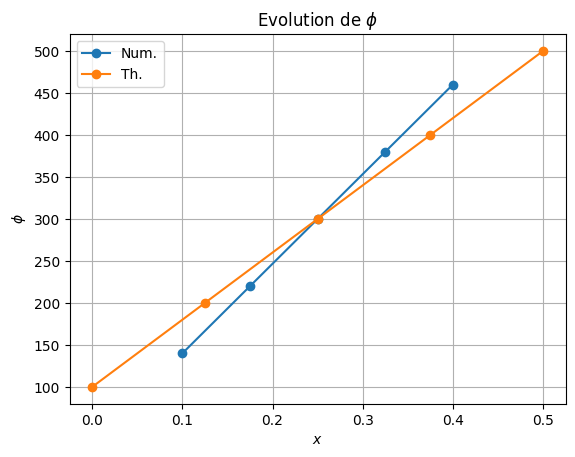

In [84]:
# Creation du maillage
N = 5                      # Nb de cellules
L = 0.5                     # Longueur du domaine
dx = L / (N)               # Pas d'espace
x = np.linspace(dx,L-dx,N) # Maillage 1D (abscisse centre des cellules)

a = np.zeros((N,N))       # Matrice du schéma numérique
s = np.zeros(N)            # Vecteur second membre

# Paramètres physiques
phiA = 100                    # Température de paroi
phiB = 500                    # Température de paroi

#
# Remplissage de la matrice du système linéaire
#

# Noeud 0 ordre 2
# aW = 0
# aE = 4/(3*dx)
# Sp = -2/dx
# Su =  8*phiA/(3*dx)
# aP = 4/dx

# Noeud 0 ordre 1 
a[0,0] = 3/dx
a[0,1] = -1/dx
s[0] = 2*phiA/dx

# Noeuds interieurs ordre 2
for i in range(1, N-1):
    a[i,i-1] = -1/dx
    a[i,i] = 2/dx
    a[i,i+1] = -1/dx
    s[i] = 0

# Noeud 4 ordre 2
# aW = 4/(3*dx)
# aE = 0
# Sp = -2/dx
# Su =  8*TB/(3*dx)
# aP = 4/dx

# Noeud 4 ordre 1
a[N-1,N-2] = -1/dx
a[N-1,N-1] = 3/dx
s[N-1] = 2*phiB/dx

# Calcul de la solution
phi = np.linalg.solve(a,s)

# Solution analytique
x_ana = np.linspace(0,L,N)
phi_ana = (phiB-phiA)*x_ana/L+phiA

# Affichage de la solution
plt.figure()
plt.grid()
plt.title(r"Evolution de $\phi$")
plt.plot(x,phi,'-o',label="Num.")
plt.plot(x_ana,phi_ana,'-o',label="Th.")
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.show()


In [85]:
phi

array([140., 220., 300., 380., 460.])

## Influence du maillage


Afin de tester l'influence de la discrétisation spatiale sur les résultats et montrer une convergence en maillage testons différents niveaux de discrétisation :
 - $N=5$
 - $N = 10$
 - $N = 100$

 Pour cela il est plus facile de créer une fonction qui va ,entre autre, prendre comme argument le nombre de cellules $N$ du maillage.

In [86]:
def diffusion(L,N,phiA,phiB):
    # Creation du maillage
    dx = L / (N)               # Pas d'espace
    x = np.linspace(dx,L-dx,N) # Maillage 1D (abscisse centre des cellules)

    a = np.zeros((N,N))       # Matrice du schéma numérique
    s = np.zeros(N)            # Vecteur second membre

    #
    # Remplissage de la matrice du système linéaire
    #

    # Noeud 0 ordre 1 
    a[0,0] = 3/dx
    a[0,1] = -1/dx
    s[0] = 2*phiA/dx

    # Noeuds interieurs ordre 2
    for i in range(1, N-1):
        a[i,i-1] = -1/dx
        a[i,i] = 2/dx
        a[i,i+1] = -1/dx
        s[i] = 0

    # Noeud 4 ordre 1
    a[N-1,N-2] = -1/dx
    a[N-1,N-1] = 3/dx
    s[N-1] = 2*phiB/dx

    # Calcul de la solution
    phi = np.linalg.solve(a,s)

    # Renvoi de la solution
    return x, phi

In [87]:
# Résolutions des différents maillages
N1 = 5
N2 = 10
N3 = 100

# Paramètres physiques
L= 0.5 
phiA = 100                    # Température de paroi
phiB = 500                    # Température de paroi

# Solutions obtenues pour les différents maillages
x1, phi1 = diffusion(L,N1,phiA,phiB)
x2, phi2 = diffusion(L,N2,phiA,phiB)
x3, phi3 = diffusion(L,N3,phiA,phiB)

# Solution analytique
x_ana = np.linspace(0,L,N1)
phi_ana = (phiB-phiA)*x_ana/L+phiA


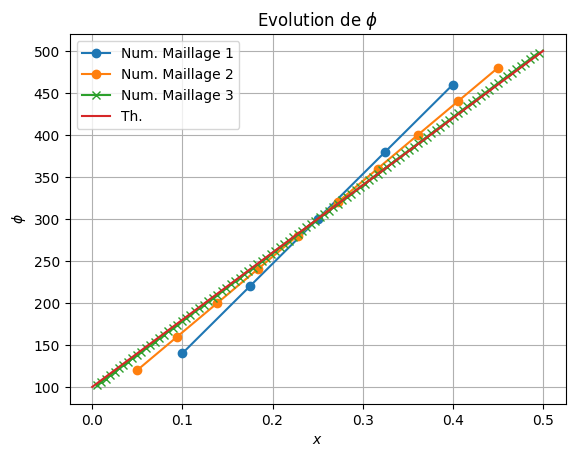

In [88]:
# Affichage de la solution
plt.figure()
plt.grid()
plt.title(r"Evolution de $\phi$")
plt.plot(x1,phi1,'-o',label="Num. Maillage 1")
plt.plot(x2,phi2,'-o',label="Num. Maillage 2")
plt.plot(x3,phi3,'-x',label="Num. Maillage 3")
plt.plot(x_ana,phi_ana,'-',label="Th.")
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.show()

## Résolution par la méthode de Gauss-Seidel

In [89]:
def gauss_seidel(a,b,eps):
    """
    Resoud un systeme d'eq; lineaires de la forme Ax = b avec la methode iterative de Gauss-Seidel
    'A': Matrice (n, n)
    'b': Second membre (n, 1)
    'tol': tolerance a atteindre
    'maxIter': nb max d'iterations
    """
    # Dimension de la matrice
    nLig, nCol = np.shape(a)
    n = nLig  # Dimension de la matrice a(n,n)
    
    # Initialisation
    x0 = np.zeros(n) * 5  
    iter = 0
    x=x0 # Initialisation de la solution à l'iteration 0 : x^0
    residu=np.linalg.norm(np.dot(a,x)-b) # Residu initial
    
    # Boucle du processus iteratif
    while (residu > eps):
        for i in range(n):
            sigma = 0
            for j in range(n):
                if j != i:
                    sigma += a[i, j] * x[j] # Calcul de la somme des termes sauf celui de la diagonale
            x[i] = (b[i] - sigma) / a[i, i]
            
        # Actualisation residu
        residu = np.linalg.norm(np.dot(a,x)-b)
        
        # On incrémente l'iteration
        iter += 1
        
    return [x,iter,residu] 

In [90]:
def diffusion_gs(L,N,phiA,phiB,eps):
    # Creation du maillage
    dx = L / (N)               # Pas d'espace
    x = np.linspace(dx,L-dx,N) # Maillage 1D (abscisse centre des cellules)

    a = np.zeros((N,N))       # Matrice du schéma numérique
    s = np.zeros(N)            # Vecteur second membre

    #
    # Remplissage de la matrice du système linéaire
    #

    # Noeud 0 ordre 1 
    a[0,0] = 3/dx
    a[0,1] = -1/dx
    s[0] = 2*phiA/dx

    # Noeuds interieurs ordre 2
    for i in range(1, N-1):
        a[i,i-1] = -1/dx
        a[i,i] = 2/dx
        a[i,i+1] = -1/dx
        s[i] = 0

    # Noeud 4 ordre 1
    a[N-1,N-2] = -1/dx
    a[N-1,N-1] = 3/dx
    s[N-1] = 2*phiB/dx

    # Calcul de la solution
    phi,iter,res = gauss_seidel(a, s, eps)
    print("La solution est obtenue avec un résidu de ",res," en ",iter," iterations")
    
    # Renvoi de la solution
    return x, phi

In [91]:
# Maillage
N = 50                # Nb de cellules
L = 0.5               # Longueur du domaine

# Paramètres physiques
phiA = 100        # Température de paroi
phiB = 500        # Température de paroi

# Calcul de la solution par methode directe
x, phi = diffusion(L,N,phiA,phiB)

# Calcul de la solution par la méthode de Gauss-Seidel
eps = 1e-2
x_gs, phi_gs = diffusion_gs(L,N,phiA,phiB,eps)

# Solution analytique
x_ana = np.linspace(0,L,N)
phi_ana = (phiB-phiA)*x_ana/L+phiA

La solution est obtenue avec un résidu de  0.009982727120638388  en  2853  iterations


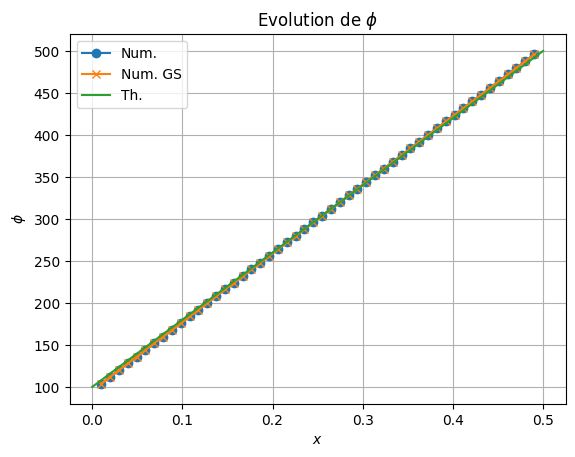

In [92]:
# Affichage de la solution
plt.figure()
plt.grid()
plt.title(r"Evolution de $\phi$")
plt.plot(x,phi,'-o',label="Num.")
plt.plot(x_gs,phi_gs,'-x',label="Num. GS")
plt.plot(x_ana,phi_ana,'-',label="Th.")
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.show()

In [93]:
phi

array([104., 112., 120., 128., 136., 144., 152., 160., 168., 176., 184.,
       192., 200., 208., 216., 224., 232., 240., 248., 256., 264., 272.,
       280., 288., 296., 304., 312., 320., 328., 336., 344., 352., 360.,
       368., 376., 384., 392., 400., 408., 416., 424., 432., 440., 448.,
       456., 464., 472., 480., 488., 496.])

In [94]:
phi_gs

array([103.99983359, 111.99950274, 119.99917516, 127.99885212,
       135.99853488, 143.99822467, 151.99792268, 159.99763007,
       167.99734795, 175.99707741, 183.99681945, 191.99657505,
       199.99634512, 207.9961305 , 215.99593198, 223.99575029,
       231.99558606, 239.99543989, 247.99531226, 255.99520363,
       263.99511433, 271.99504464, 279.99499477, 287.99496483,
       295.99495485, 303.99496481, 311.99499457, 319.99504396,
       327.99511269, 335.99520041, 343.99530671, 351.9954311 ,
       359.99557301, 367.99573181, 375.99590681, 383.99609726,
       391.99630235, 399.99652121, 407.99675291, 415.99699651,
       423.99725099, 431.9975153 , 439.99778837, 447.99806907,
       455.99835629, 463.99864885, 471.99894559, 479.99924531,
       487.99954683, 495.99984894])

In [ ]:
def Jacobi(A,b,x0,eps):
    # Initialisations
    k=0
    x=x0             # x_{k}
    x_precedent=x0   # x_{k-1}
    residu=norm(dot(A,x)-b)
    i,j = np.indices(A.shape)
    while(residu>eps):
        # On incrémente indice
        k+=1
        # Actualisation x_precedent
        x_precedent=x
        # Nouvelle solution x utilisant x_precedent
        x=(b-dot(A-diag(diag(A)),x_precedent))/diag(A)
        # Actualisation residu
        residu=norm(dot(A,x)-b)    
    return [x,k,residu]


In [7]:
def gauss_seidel2(a, b, tol=1e-12, maxIter=10000):
    """
    Resoud un systeme d'eq; lineaires de la forme Ax = b avec la methode iterative de Gauss-Seidel
    'A': Matrice (n, n)
    'b': Second membre (n, 1)
    'tol': tolerance a atteindre
    'maxIter': nb max d'iterations
    """
    iters = 1  # Iteration du processus

    nLig, nCol = np.shape(a)
    n = nLig  # Dimension de la matrice a(n,n)
    x = np.random.rand(n) * 5  # Initialisation de la solution à l'iteration 0
    sigmaTol = 1  # Pour calcul de la tolerance

    while True:
        if iters > maxIter:
            print("Le Nb max d'iterations est atteint. Fin.")
            break

        for i in range(n):
            sigma = 0
            for j in range(n):
                if j != i:
                    sigma += a[i, j] * x[j]
            x[i] = (b[i] - sigma) / a[i, i]

        tolerance = abs(sigmaTol - sigma)
        if tolerance <= tol:
            print("La precision visee est atteinte en \t %d iterations." % (iters))
            break

        sigmaTol = sigma
        iters += 1

    return x